In [ ]:
!pip uninstall -y transformers
!pip install transformers==4.51.3
!pip install -U datasets scikit-learn

Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have

# New Section

# New Section

In [ ]:
import transformers
print(transformers.__version__)

4.51.3


In [ ]:
from google.colab import files
from datasets import load_dataset

uploaded = files.upload()

train_dataset = load_dataset("json", data_files="train.json1")["train"]
val_dataset = load_dataset(
    "csv",
    data_files="dev.csv",
    delimiter=","
)["train"]

Saving train.json1 to train.json1
Saving dev.csv to dev.csv


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(train_dataset[0])
print(val_dataset[0])

{'text': '− Scope 3: Optional scope that includes indirect emissions associated with the goods and services supply chain produced outside the organization. Included are emissions from the transport of products from our logistics centres to stores (downstream) performed by external logistics operators (air, land and sea transport) as well as the emissions associated with electricity consumption in franchise stores.', 'label': 1}
{'text': 'Sustainable strategy ‘red lines’ For our sustainable strategy range, we incorporate a series of proprietary ‘red lines’ in order to ensure the poorest- performing companies from an ESG perspective are not eligible for investment.', 'label': 0}


In [ ]:
import pandas as pd

df = pd.read_json("train.json1", lines=True)
num_labels = df["label"].nunique()

In [ ]:
import os
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset

hf_token = os.environ.get("HF_TOKEN")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", use_auth_token=hf_token)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels, use_auth_token=hf_token)

# tokenize
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        "accuracy": acc,
        "f1": f1
    }

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_steps=10
)

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kechan1 (kechan-butterr12) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.591300,0.562780,0.762500,0.759031
2,0.388400,0.610768,0.737500,0.734419
3,0.293200,0.541311,0.806250,0.808152


TrainOutput(global_step=375, training_loss=0.4558935915629069, metrics={'train_runtime': 4743.8274, 'train_samples_per_second': 0.632, 'train_steps_per_second': 0.079, 'total_flos': 197335063296000.0, 'train_loss': 0.4558935915629069, 'epoch': 3.0})

In [ ]:
model.save_pretrained("model/")
tokenizer.save_pretrained("model/")

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json')

In [ ]:
!zip -r model.zip model/

  adding: model/ (stored 0%)
  adding: model/tokenizer_config.json (deflated 75%)
  adding: model/model.safetensors (deflated 7%)
  adding: model/special_tokens_map.json (deflated 42%)
  adding: model/config.json (deflated 51%)
  adding: model/vocab.txt (deflated 53%)


In [ ]:
from google.colab import files
files.download("model.zip")

In [ ]:
# Upload and load test.csv
uploaded = files.upload()

import pandas as pd
from datasets import Dataset

# Load test.csv (must have 'text' and 'label' columns)
df_test = pd.read_csv("test.csv")
test_dataset = Dataset.from_pandas(df_test)

# Tokenize test dataset
test_dataset = test_dataset.map(tokenize, batched=True)
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Evaluate on test set using the trainer
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print("Test Metrics:", test_metrics)

# Optionally: get individual predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Save predicted vs actual labels
df_test["predicted_label"] = preds
df_test.to_csv("test_predictions.csv", index=False)

from google.colab import files
files.download("test_predictions.csv")

Saving test.csv to test.csv


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Test Metrics: {'eval_loss': 0.553771436214447, 'eval_accuracy': 0.79375, 'eval_f1': 0.799802436975656, 'eval_runtime': 75.9026, 'eval_samples_per_second': 2.108, 'eval_steps_per_second': 0.263, 'epoch': 3.0}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Count total, correct, and incorrect predictions
actual = df_test["label"].values
correct = (actual == preds).sum()
incorrect = (actual != preds).sum()
total = len(actual)
accuracy = accuracy_score(actual, preds)
f1 = f1_score(actual, preds, average='weighted')

print(f"Total samples: {total}")
print(f"Correct predictions: {correct}")
print(f"Incorrect predictions: {incorrect}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Total samples: 160
Correct predictions: 127
Incorrect predictions: 33
Accuracy: 0.7937
F1 Score: 0.7998


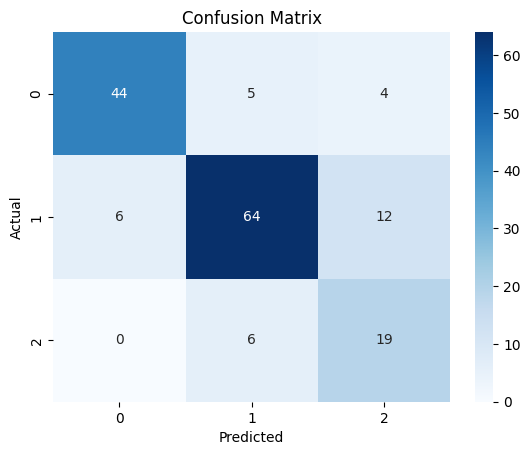

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(actual, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()